In [1]:
import h5py
import time
import matplotlib
import numpy as np
from obspy import UTCDateTime
from das_util import next_power_of_2
from matplotlib import pyplot as plt

%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})

In [12]:
# %% read from the saved HDF5
datah5 = '/data/whd01/qibin_data/farmDAS_harper_0_24hr.hdf5'
with h5py.File(datah5, 'r') as f:
    f_sample = f["dt"][()]
    st_pt=int(233*60*f_sample); en_pt=st_pt+100*60*f_sample
    full_time_data = f["data"][:]
    time_stamp = f["timestamp"][:]
    
utc = np.array([UTCDateTime(i) for i in time_stamp])
nsec = int(full_time_data.shape[1]/f_sample) # total time of merged time series

2160.0 (2408,)


## F-K filter

300000 50 padded to 524288 64 100


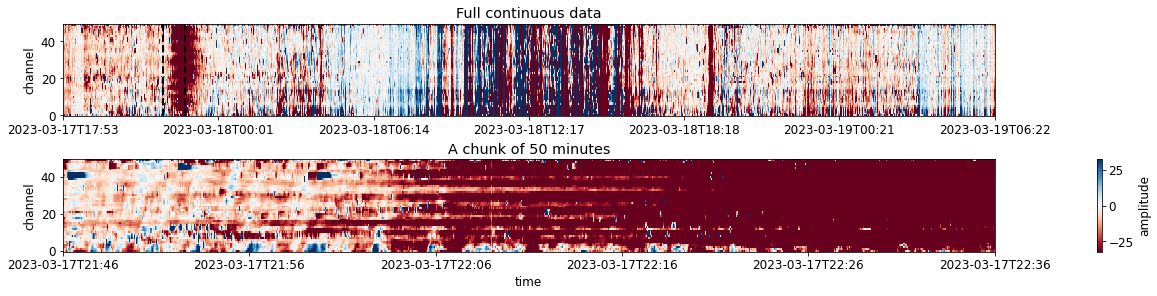

In [11]:
# %% extract a portion of the farm DAS
st_pt=int(233*60*f_sample); en_pt=st_pt+50*60*f_sample
vsp = full_time_data[:, st_pt:en_pt].T
n1, n2 = vsp.shape

nf = next_power_of_2(n1)
nk = next_power_of_2(n2)
nf2=int(nf/2)
nk2=int(nk/2)
print(n1, n2, 'padded to', nf, nk, f_sample)

# %% plot data in time-space
fig, ax = plt.subplots(2, 1, figsize=(16, 4), constrained_layout=True)
max_amp = np.percentile(np.fabs(full_time_data), q=80)
cmap=plt.cm.get_cmap('RdBu')

x=np.arange(full_time_data.shape[1])
y=np.arange(full_time_data.shape[0])
ax[0].pcolormesh(x, y, full_time_data, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
ax[0].set_xticks(np.linspace(0,nsec*f_sample,7))
ax[0].set_xticklabels(utc[(np.linspace(0,nsec/60,7)).astype(int)].astype('datetime64[m]'))
ax[0].set_ylabel('channel'); ax[0].set_title('Full continuous data')
ax[0].axvline(x=st_pt, color='k', lw=2, ls='--')
ax[0].axvline(x=en_pt, color='k', lw=2, ls='--')

x=np.arange(vsp.shape[0])
y=np.arange(vsp.shape[1])
ax[1].pcolormesh(x, y, vsp.T, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
ax[1].set_xticks(np.linspace(0,en_pt-st_pt,6))
ax[1].set_xticklabels(utc[(np.linspace(st_pt,en_pt,6)/f_sample/60).astype(int)].astype('datetime64[m]'))
ax[1].set_ylabel('channel'); ax[1].set_xlabel('time')
ax[1].set_title('A chunk of 50 minutes'); fig.colorbar(im, label='amplitude', ax=ax[1])

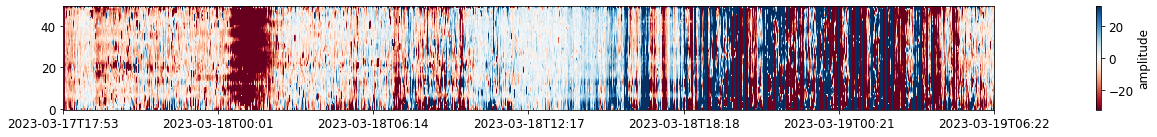

In [19]:
# %% the ERROR of imshow
fig, ax = plt.subplots(1, 1, figsize=(16, 1.8), constrained_layout=True)
im=ax.imshow(full_time_data, aspect='auto', cmap=cmap, vmax=max_amp, vmin=-max_amp, origin='lower')
ax.set_xticks(np.linspace(0,nsec*f_sample,7))
ax.set_xticklabels(utc[(np.linspace(0,nsec/60,7)).astype(int)].astype('datetime64[m]'))
fig.colorbar(im, label='amplitude', ax=ax)

### 2D fft

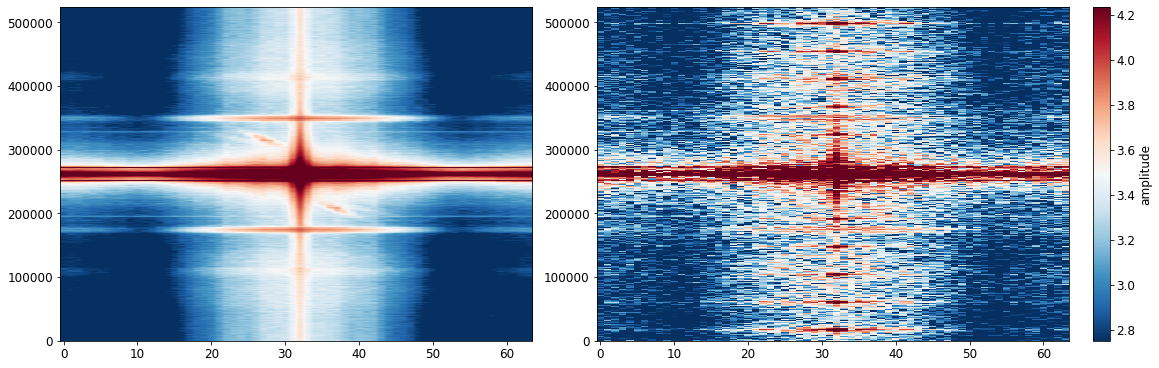

In [21]:
fk2d = np.fft.fft2(vsp, s=(nf,nk))
fk2d = np.fft.fftshift(fk2d, axes=(-2,-1))

amps = np.log10(np.abs(fk2d)).flatten()
q1=np.percentile(amps, q=25)
q2=np.percentile(amps, q=97)
x=np.arange(fk2d.shape[1])
y=np.arange(fk2d.shape[0])
fig, ax = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)
ax[0].imshow(np.log10(np.abs(fk2d)), aspect = 'auto',  cmap=cmap.reversed(), vmax=q2, vmin=q1, origin='lower')
im=ax[1].pcolormesh(x,y,np.log10(np.abs(fk2d)), shading='auto', cmap=cmap.reversed(), vmax=q2, vmin=q1)
plt.colorbar(im, ax=ax[1], label='amplitude')

### filter

In [23]:
def fk_filter_2cones(vsp, w1=0, w2=0):
    n1, n2 = vsp.shape
    nf = next_power_of_2(n1)
    nk = next_power_of_2(n2)

    nf2=int(nf/2)
    nk2=int(nk/2)
    
    fk2d = np.fft.fft2(vsp, s=(nf,nk))
    fk2d = np.fft.fftshift(fk2d, axes=(-2,-1))
    
    nw1 = int(np.ceil(w1*nk))
    nw2 = int(np.ceil(w2*nf))

    mask1=np.ones((nf,nk), dtype=np.float64)
    mask2=np.ones((nf,nk), dtype=np.float64)

    for j in np.arange(nk2-nw1, nk2+1):
        th1 = int((j-nk2+nw1) * nf2/nw1)

        mask1[:th1, j] = 0
        mask1[nf-th1:, j] = 0
        mask1[:th1, nk-j] = 0
        mask1[nf-th1:, nk-j] = 0

    for j in np.arange(0, nk2):
        th2 = int(nf2 - (nw2/nk2)*(nk2-j))
        mask2[th2:nf-th2+1, j] = 0
        if j != 0:
            mask2[th2:nf-th2+1, nk-j] = 0


    mask = mask2*mask1
    
    filtered_2d = fk2d * mask
    tmp = np.fft.ifftshift(filtered_2d)
    output = np.fft.ifft2(tmp, s=(nk,nf), axes=(-1, -2))
    
    return output[:n1,:n2], filtered_2d

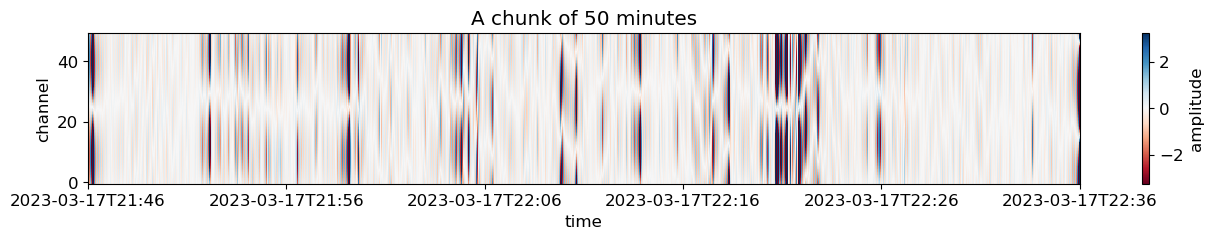

In [58]:
# %%  use the cone-shape filter
filt_data, filtered_2d = fk_filter_2cones(vsp, w1=5e-2, w2=5e-2)

# %%  Visualize the filtered DAS in space and time
plt.figure(figsize=(16, 2), dpi=100)
plt.imshow(filt_data.real.T, aspect='auto', cmap=cmap, vmax=max_amp/10, vmin=-max_amp/10, origin='lower')
plt.xticks(np.linspace(0,en_pt-st_pt,6), utc[(np.linspace(st_pt,en_pt,6)/f_sample/60).astype(int)].astype('datetime64[m]'))
plt.ylabel('channel'); plt.xlabel('time'); plt.title('A chunk of 50 minutes'); plt.colorbar(label='amplitude')

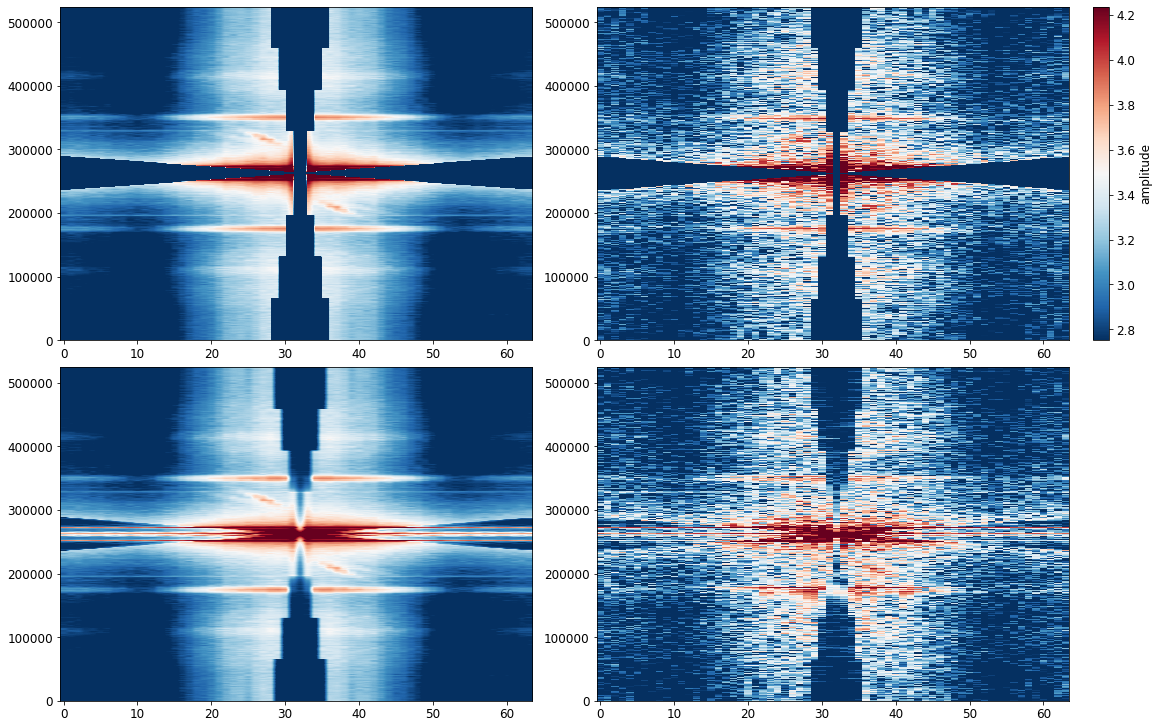

In [59]:
# %%  Visualize the FK mask
x=np.arange(filtered_2d.shape[1])
y=np.arange(filtered_2d.shape[0])
z=np.log10(np.abs(filtered_2d)+1e-20)
fig, ax = plt.subplots(2, 2, figsize=(16, 10), constrained_layout=True)
ax[0,0].imshow(z, aspect = 'auto',  cmap=cmap.reversed(), vmax=q2, vmin=q1, origin='lower')
im=ax[0,1].pcolormesh(x,y,z, shading='auto', cmap=cmap.reversed(), vmax=q2, vmin=q1)
plt.colorbar(im, ax=ax[0,1], label='amplitude')

# %%  transform the filtered data back
back_fk = np.fft.fftshift(np.fft.fft2(filt_data.real, s=(nf,nk)), axes=(-2,-1))
x=np.arange(back_fk.shape[1])
y=np.arange(back_fk.shape[0])
z=np.log10(np.abs(back_fk)+1e-20)
ax[1,0].imshow(z, aspect = 'auto',  cmap=cmap.reversed(), vmax=q2, vmin=q1, origin='lower')
im=ax[1,1].pcolormesh(x,y,z, shading='auto', cmap=cmap.reversed(), vmax=q2, vmin=q1)

### compare with the one-direction mask

In [60]:
def fk_filt(tr_in,fs,dx,sgn='pos',cmin=1,cmax=50):
    ''' F-K filtering between cmin and cmax contours '''
    Ns = tr_in.shape[0]
    Nx = tr_in.shape[1]
    
    f0 = np.fft.fftshift(np.fft.fftfreq(Ns,d=1./fs))
    k0 = np.fft.fftshift(np.fft.fftfreq(Nx,d=dx))
    ft2 = np.fft.fftshift(np.fft.fft2(tr_in))
    K, F = np.meshgrid(k0,f0)
    C = F/(K+1e-20)
    filt = np.zeros(ft2.shape)
    if sgn=='pos': 
        filt[np.logical_and(C>cmin,C<cmax)] = 1.
    else:
        filt[np.logical_and(C<-cmin,C>-cmax)] = 1.
    
    ft2f = ft2*filt
    tr_out = np.fft.ifft2(np.fft.fftshift(ft2f), s=(Nx,Ns), axes=(-1, -2))
    
    plt.figure(figsize=(10, 4), dpi=100)
    plt.imshow(np.log10(np.abs(ft2f)+1e-20), aspect='auto', cmap = cmap.reversed(), origin='lower', vmin=q1, vmax=q2)
    plt.colorbar(label='power density')
    
    return tr_out

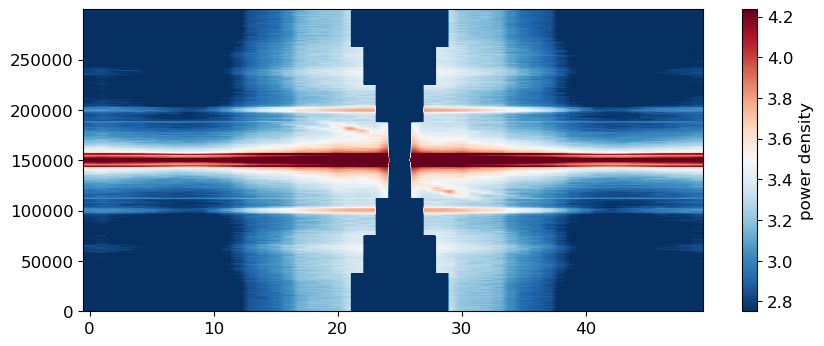

In [61]:
filt_data = fk_filt(vsp, 100, 3.2, sgn='pos', cmin=-2000, cmax=2000)

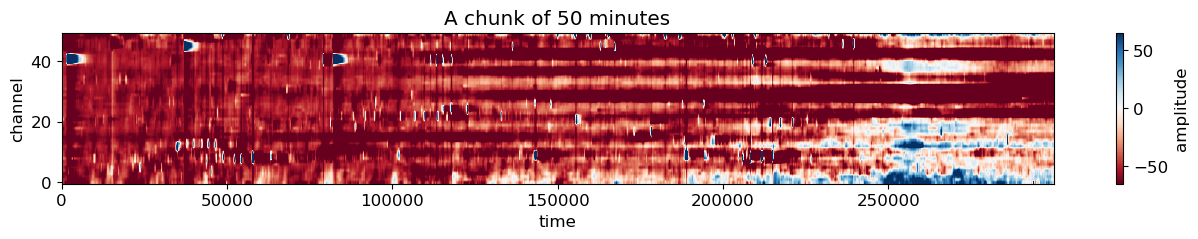

In [62]:
# %%  Visualize the filtered DAS in space and time
plt.figure(figsize=(16, 2), dpi=100)
plt.imshow(filt_data.real.T, aspect='auto', cmap=cmap, vmax=max_amp*2, vmin=-max_amp*2, origin='lower')
plt.ylabel('channel'); plt.xlabel('time'); plt.title('A chunk of 50 minutes'); plt.colorbar(label='amplitude')

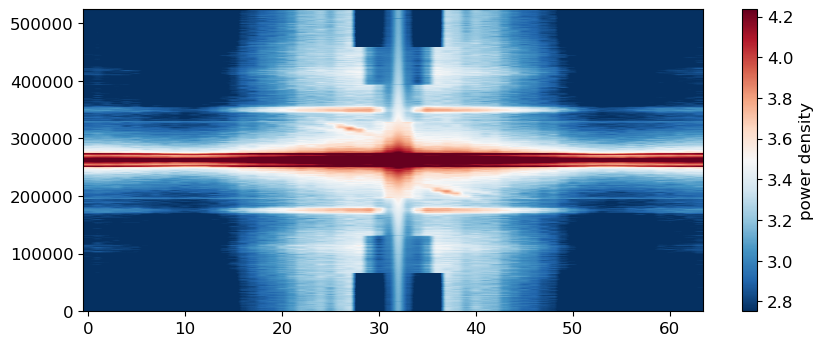

In [65]:
# %%  transform the filtered data back
plt.figure(figsize=(10, 4), dpi=100)
back_fk = np.fft.fftshift(np.fft.fft2(filt_data.real, s=(nf,nk)), axes=(-2,-1))
plt.imshow(np.log10(np.abs(back_fk)+1e-20), aspect='auto', cmap=cmap.reversed(), vmax=q2, vmin=q1, origin='lower')
plt.colorbar(label='power density')

## Test on AK DAS

### Earthquake

In [70]:
datah5 = '/data/whd01/qibin_data/akdas/decimator2_2023-06-18_09.15.03_UTC.h5'
with h5py.File(datah5, 'r') as f:
    time_data = f['Acquisition']['Raw[0]']['RawData'][:1500, 0:8500]
    delta_space = f['Acquisition'].attrs['SpatialSamplingInterval']
    sample_rate = f['Acquisition']['Raw[0]'].attrs['OutputDataRate']
   
print(time_data.shape, delta_space, sample_rate)

(1500, 8500) 9.571428805203961 25.0


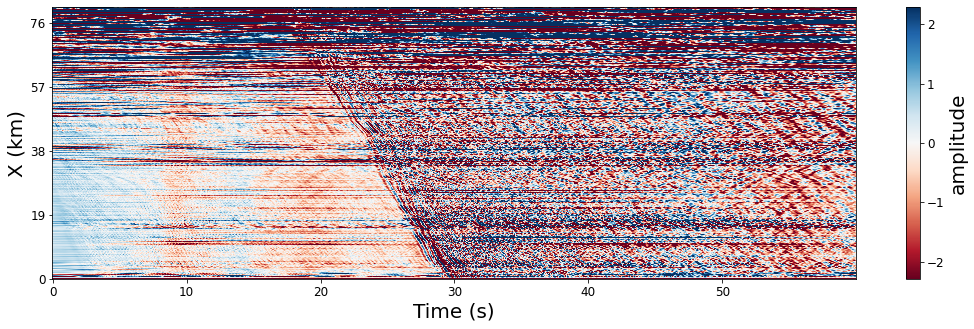

In [71]:
max_amp = np.median(np.fabs(time_data))
plt.figure(figsize=(18, 5))
plt.imshow(time_data.T, aspect = 'auto', cmap = 'RdBu', vmax = max_amp/2, vmin = -max_amp/2, origin='lower')
plt.ylabel("X (km)", fontsize=20)
plt.xlabel("Time (s)", fontsize=20)
plt.xticks(np.arange(0, 1500, 250), np.arange(0, 1500/sample_rate, 250/sample_rate).astype(int))
plt.yticks(np.arange(0, 8500, 2000), (np.arange(0, delta_space*8500, 2000*delta_space)/1000).astype(int))

cbr=plt.colorbar()
cbr.set_label('amplitude', fontsize = 20)

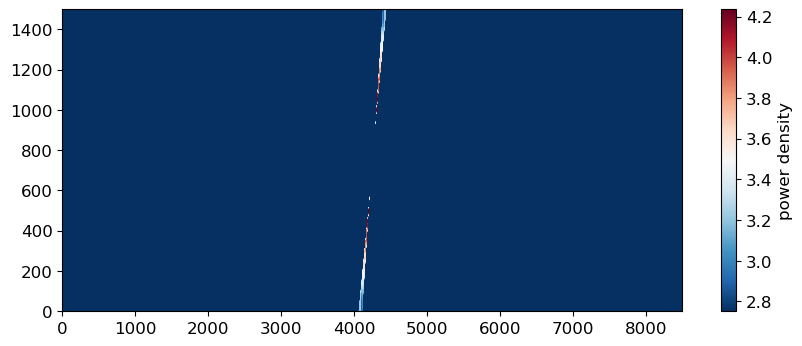

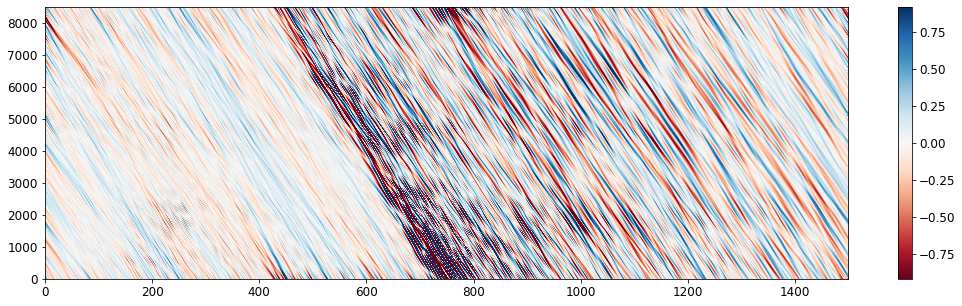

In [75]:
# %% FK filter by Ethan Williams to extract one-direction wave
filt_data = fk_filt(time_data, sample_rate, delta_space, sgn='pos', cmin=5000, cmax=8000)
plt.figure(figsize=(18, 5))
plt.imshow(filt_data.real.T, aspect = 'auto', cmap = 'RdBu', vmax = max_amp/5, vmin = -max_amp/5, origin='lower')
plt.colorbar()

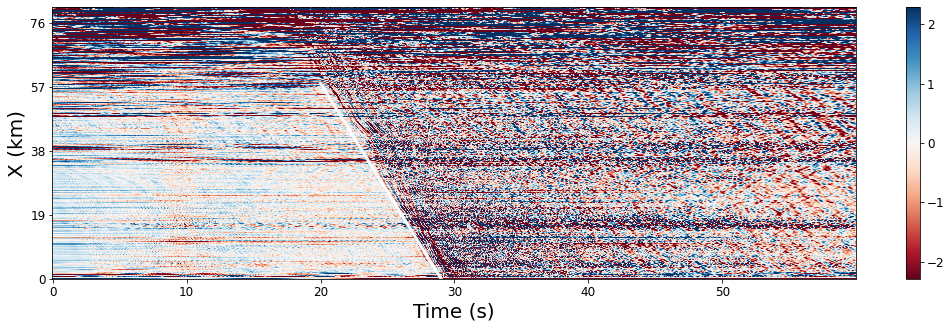

In [76]:
# %% Use cone-filter
filt_data, filtered_fk = fk_filter_2cones(time_data, w1=0.000001, w2=0)
# filt_data, filtered_fk = fk_filter_2cones(filt_data.real, w1=0.000001, w2=0)
plt.figure(figsize=(18, 5))
plt.imshow(filt_data.real.T, aspect = 'auto', cmap = 'RdBu', vmax = max_amp/2, vmin = -max_amp/2, origin='lower')
plt.colorbar()
plt.xticks(np.arange(0, 1500, 250), np.arange(0, 1500/sample_rate, 250/sample_rate).astype(int))
plt.yticks(np.arange(0, 8500, 2000), (np.arange(0, delta_space*8500, 2000*delta_space)/1000).astype(int))
plt.ylabel("X (km)", fontsize=20)
plt.xlabel("Time (s)", fontsize=20)

# %% plot the slope of S wave onset
slope = 6500 # m/s
x = np.arange(20, 30, 1)
y = 0 - (x - 29) * slope
x = x * sample_rate
y = y / delta_space
plt.plot(x, y, lw=3, color='w')

0.2089552187769641


/tmp/ipykernel_210013/62908427.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(filtered_fk)), aspect = 'auto', cmap = cmap.reversed(), origin='lower',vmax=q2*1.1, vmin=q1)


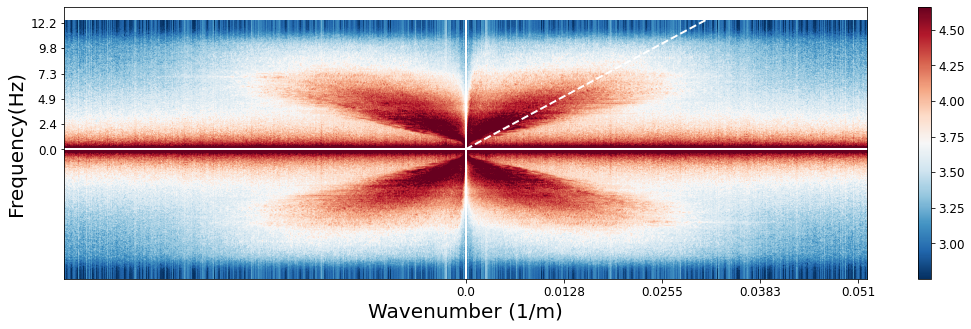

In [77]:
f0 = np.fft.fftshift(np.fft.fftfreq(next_power_of_2(1500),d=1./sample_rate))
k0 = np.fft.fftshift(np.fft.fftfreq(next_power_of_2(8500),d=delta_space))
df = f0[1]-f0[0]
dk = k0[1]-k0[0]

plt.figure(figsize=(18, 5))
plt.imshow(np.log10(np.abs(filtered_fk)), aspect = 'auto', cmap = cmap.reversed(), origin='lower',vmax=q2*1.1, vmin=q1)
plt.colorbar()
plt.xticks(np.arange(int(len(k0)/2), len(k0), 2000), np.round(k0[np.arange(int(len(k0)/2), len(k0), 2000)], decimals=4))
plt.yticks(np.arange(int(len(f0)/2), len(f0), 200), np.round(f0[np.arange(int(len(f0)/2), len(f0), 200)], decimals=1))
plt.xlabel("Wavenumber (1/m)", fontsize=20)
plt.ylabel("Frequency(Hz)", fontsize=20)


# %% plot the slope of S wave onset
slope = 400 # m/s
slope_pt = slope / df * dk
print(slope_pt)
x = np.arange(int(len(k0)/2), len(k0), 10)
y = (x - x[0]) * slope_pt + len(f0)/2
x = x[y<len(f0)]
y = y[y<len(f0)]
plt.plot(x, y, lw=2, color='w', ls='--')